[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/vik0/LangevinDQN/blob/main/LangevinDQN_tutorial.ipynb)

# Langevin DQN 

Colab to run a simple experiment with Langevin DQN on deep sea environment. The aim of this colab is to provide sample code to run Langevin DQN and Ensemble Langevin DQN on bsuite environments. 

In this code,
- We run Langevin DQN (with a single point estimate) on a deep sea environment of depth $10$.
- We run Ensemble Langevin DQN (with size 10) on a deep sea environment of depth $10$. 

Please upload the notebook to [google colaboratory](https://colab.research.google.com/) to run it.


## Imports

In [7]:
#@title Installing bsuite
%%capture
!pip install bsuite[baselines]

In [ ]:
# @title Clone the LangevinDQN repository  
os.chdir('/content')
!git clone https://github.com/vik0/LangevinDQN.git

In [8]:
#@title Imports

# pylint: disable=unused-import

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import glob 

import warnings
import numpy as np
import pandas as pd

import time
import bsuite
from bsuite.experiments import summary_analysis
from bsuite.logging import csv_load
from bsuite.logging import sqlite_load

from bsuite import sweep

import matplotlib.pyplot as plt
import os
import subprocess


## Run LangevinDQN (point estimate) on deep sea environment of depth 10 

In [11]:
# @title run the experiment

import tensorflow as tf
import sonnet as snt

os.chdir('/content/LangevinDQN')
from agent import EnsembleLangevinDqn
from agent import make_ensemble

num_episodes = 1000
depth = 10
seed = 42
sgds = 10
learning_rate = 0.01
noise_scale = 0.005
regularization_penalty = 0.005 
relu_alpha = 0.1

np.random.seed(seed)
tf.random.set_seed(seed)

env = bsuite.load('deep_sea', {'size': depth,  'seed': seed})

ensemble = make_ensemble(
      num_actions=env.action_spec().num_values,
      num_ensemble=1,
      num_hidden_layers=2,
      num_units=50,
      prior_scale=0,
      relu_alpha=relu_alpha,
      with_bias=True,
      )

agent = EnsembleLangevinDqn(
      obs_spec=env.observation_spec(), action_spec=env.action_spec(),
      ensemble=ensemble, num_ensemble=1,
      batch_size=128, discount=0.99,
      replay_capacity=10_000, min_replay_size=0, target_update_period=4,
      sgds_per_step=sgds, update_every_step=False,
      optimizer=snt.optimizers.Adam(learning_rate=learning_rate,
                                    epsilon=1e-6),
      mask_prob=1, noise_scale=noise_scale, epsilon_fn=lambda x: 0,
      regularization_penalty = regularization_penalty,
      seed=seed)


results = []
cumulative_reward = 0
cumulative_regret = 0
for t in range(num_episodes):
  # Run an episode.
  reward = 0
  timestep = env.reset()
  while not timestep.last():
    # Generate an action from the agent's policy.
    action = agent.select_action(timestep)

    # Step the environment.
    new_timestep = env.step(action)
    reward += np.around(new_timestep.reward, 3)

    # Tell the agent about what just happened.
    agent.update(timestep, action, new_timestep)

    # Book-keeping.
    timestep = new_timestep

  cumulative_reward +=  reward
  cumulative_regret +=  0.99 - reward
  result = {'episode': t,
            'reward': reward,
            'regret': 0.99-reward,
            'cumulative_reward': cumulative_reward,
            'cumulative_regret': cumulative_regret}
  results.append(result)
  if (t%100 == 0):
    np.set_printoptions(precision=3, suppress=True)
    print(result)

df = pd.DataFrame(results)

{'episode': 0, 'reward': -0.002, 'regret': 0.992, 'cumulative_reward': -0.002, 'cumulative_regret': 0.992}
{'episode': 100, 'reward': -0.005, 'regret': 0.995, 'cumulative_reward': -0.5710000000000004, 'cumulative_regret': 100.561}
{'episode': 200, 'reward': -0.005, 'regret': 0.995, 'cumulative_reward': -1.1339999999999992, 'cumulative_regret': 200.12400000000017}
{'episode': 300, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 94.87799999999989, 'cumulative_regret': 203.1120000000002}
{'episode': 400, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 193.87800000000033, 'cumulative_regret': 203.1120000000002}
{'episode': 500, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 292.87800000000124, 'cumulative_regret': 203.1120000000002}
{'episode': 600, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 391.87800000000215, 'cumulative_regret': 203.1120000000002}
{'episode': 700, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 490.87800000000306, 'cumulative_regret': 203.11200

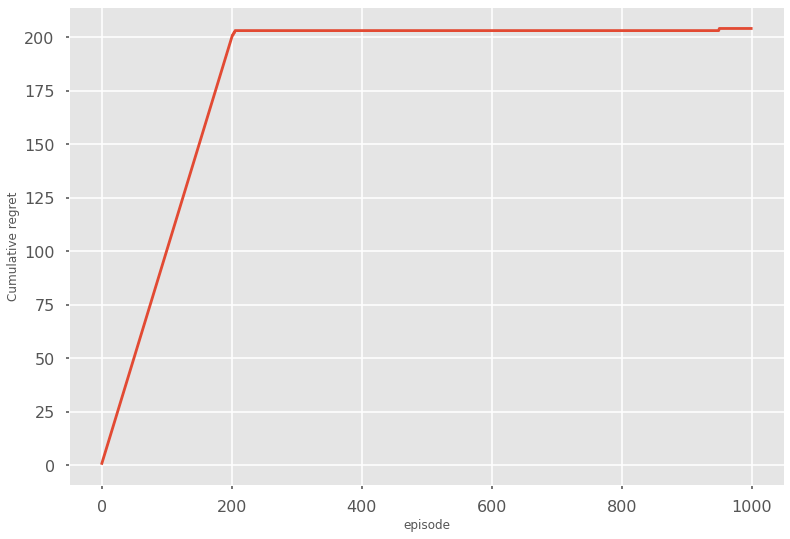

In [12]:
# @title plot the results
plt.figure()
plt.plot(df.episode, df.cumulative_regret)
plt.ylabel('Cumulative regret')
plt.xlabel('episode')
plt.title('Langevin DQN on deep sea environment of depth $10$')
plt.show()

## Run Ensemble LangevinDQN (10) on deep sea environment of depth 10 

In [14]:
# @title run the experiment

import tensorflow as tf
import sonnet as snt

os.chdir('/content/LangevinDQN')
from agent import EnsembleLangevinDqn
from agent import make_ensemble

num_episodes = 1000
depth = 10
seed = 42

sgds = 1
learning_rate = 0.001
noise_scale = 0.0001
num_ensemble = 10
prior_scale = 3

np.random.seed(seed)
tf.random.set_seed(seed)

env = bsuite.load('deep_sea', {'size': depth,  'seed': seed})

ensemble = make_ensemble(
      num_actions=env.action_spec().num_values,
      num_ensemble=num_ensemble,
      num_hidden_layers=2,
      num_units=50,
      prior_scale=prior_scale,
      with_bias=True,
      )

agent = EnsembleLangevinDqn(
      obs_spec=env.observation_spec(), action_spec=env.action_spec(),
      ensemble=ensemble, num_ensemble=num_ensemble,
      batch_size=128, discount=0.99,
      replay_capacity=10_000, min_replay_size=0, target_update_period=4,
      sgds_per_step=sgds, update_every_step=False,
      optimizer=snt.optimizers.Adam(learning_rate=learning_rate,
                                    epsilon=1e-6),
      mask_prob=1, noise_scale=noise_scale, epsilon_fn=lambda x: 0,
      # regularization_penalty = regularization_penalty,
      seed=seed)


results = []
cumulative_reward = 0
cumulative_regret = 0
for t in range(num_episodes):
  # Run an episode.
  reward = 0
  timestep = env.reset()
  while not timestep.last():
    # Generate an action from the agent's policy.
    action = agent.select_action(timestep)

    # Step the environment.
    new_timestep = env.step(action)
    reward += np.around(new_timestep.reward, 3)

    # Tell the agent about what just happened.
    agent.update(timestep, action, new_timestep)

    # Book-keeping.
    timestep = new_timestep

  cumulative_reward +=  reward
  cumulative_regret +=  0.99 - reward
  result = {'episode': t,
            'reward': reward,
            'regret': 0.99-reward,
            'cumulative_reward': cumulative_reward,
            'cumulative_regret': cumulative_regret}
  results.append(result)
  if (t%100 == 0):
    np.set_printoptions(precision=3, suppress=True)
    print(result)

df = pd.DataFrame(results)

{'episode': 0, 'reward': -0.005, 'regret': 0.995, 'cumulative_reward': -0.005, 'cumulative_regret': 0.995}
{'episode': 100, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 55.17000000000002, 'cumulative_regret': 44.819999999999986}
{'episode': 200, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 154.16999999999996, 'cumulative_regret': 44.819999999999986}
{'episode': 300, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 253.17000000000087, 'cumulative_regret': 44.819999999999986}
{'episode': 400, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 352.1700000000018, 'cumulative_regret': 44.819999999999986}
{'episode': 500, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 451.1700000000027, 'cumulative_regret': 44.819999999999986}
{'episode': 600, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 550.1700000000036, 'cumulative_regret': 44.819999999999986}
{'episode': 700, 'reward': 0.99, 'regret': 0.0, 'cumulative_reward': 649.1700000000045, 'cumulative_regret': 44.81999

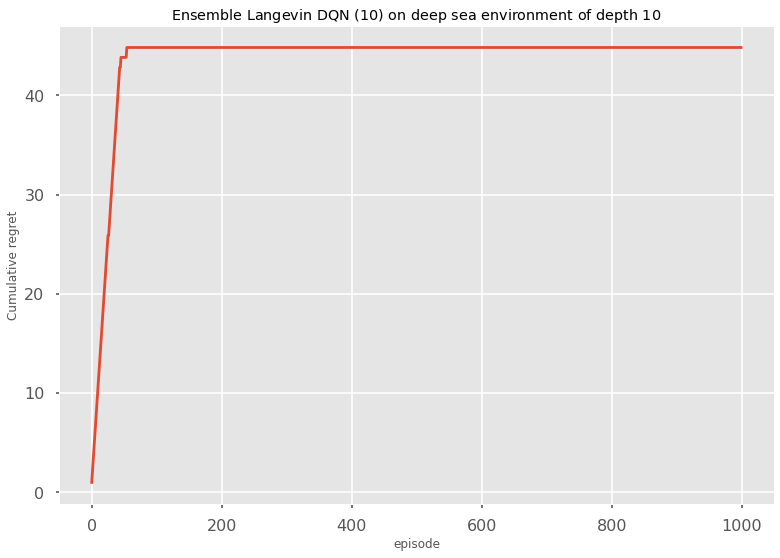

In [15]:
# @title plot the results
plt.figure()
plt.plot(df.episode, df.cumulative_regret)
plt.ylabel('Cumulative regret')
plt.xlabel('episode')
plt.title('Ensemble Langevin DQN (10) on deep sea environment of depth $10$')
plt.show()